In [1]:
# unzipp folder from drive
data = !unzip '/content/drive/MyDrive/Leaf Dataset.zip'

In [2]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import img_to_array
import imutils
from imutils import paths
import numpy as np
import cv2
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy
from google.colab.patches import cv2_imshow


In [3]:
class CNN:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)
		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
		model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
		
    # second set of CONV => RELU => POOL layers
		model.add(Conv2D(50, (5, 5), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    		
    # first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))
  
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

In [4]:

# initialize the number of epochs to train for, initia learning rate,
# and batch size
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
num_folds = 10

print("[INFO] loading images...")
Images = []
Labels = []
folders = []
def load_images_from_folder(folder):
    for foldername in os.listdir(folder):
      folders.append(foldername)
      address = os.path.join(folder,foldername)
      for filename in os.listdir(address):
        img = cv2.imread(os.path.join(address,filename))
        img = cv2.resize(img, (64, 64))
        img = img_to_array(img)
        #if using regression model
        # img = img.flatten()
        if img is not None:
            Images.append(img)
            a = os.listdir(folder).index(foldername)
            Labels.append(a)
load_images_from_folder('data')

print(folders)
print(np.unique(Labels))
np.bincount(Labels)


[INFO] loading images...
['Gray_Leaf_Spot', 'Common_Rust', 'Healthy', 'Blight']
[0 1 2 3]


array([ 574, 1306, 1162, 1146])

In [5]:

loss_function = sparse_categorical_crossentropy
Images = np.array(Images, dtype="float") / 255.0
Labels = np.array(Labels)

# Define per-fold score containers 
acc_per_fold = []
loss_per_fold = []

model = CNN.build(width=64, height=64, depth=3, classes=4)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 20)        1520      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 50)        25050     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 50)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [8]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(Images, Labels):

  print("[INFO] compiling model...")
  model.compile(loss=loss_function, 
                  optimizer=Adam(),
	                metrics=["accuracy"])
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(Images[train], Labels[train],
              batch_size=BS,
              epochs=EPOCHS,
              # validation_data=(Images[test], labels[test]),
              steps_per_epoch=len(Images[train]) // BS,
              # steps_per_epoch=64,
              verbose=1)

  # Generate generalization metrics
  print('validation loss & accuracy:\n')
  scores = model.evaluate(Images[test], Labels[test], verbose=1)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1


[INFO] compiling model...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
117/117 [==============================] - 33s 281ms/step - loss: 0.3667 - accuracy: 0.8499
Epoch 2/10
117/117 [==============================] - 33s 279ms/step - loss: 0.2936 - accuracy: 0.8807
Epoch 3/10
117/117 [==============================] - 33s 279ms/step - loss: 0.2292 - accuracy: 0.9031
Epoch 4/10
117/117 [==============================] - 32s 276ms/step - loss: 0.1878 - accuracy: 0.9245
Epoch 5/10
117/117 [==============================] - 33s 278ms/step - loss: 0.1763 - accuracy: 0.9275
Epoch 6/10
117/117 [==============================] - 32s 278ms/step - loss: 0.1252 - accuracy: 0.9518
Epoch 7/10
117/117 [==============================] - 33s 280ms/step - loss: 0.1011 - accuracy: 0.9657
Epoch 8/10
117/117 [==============================] - 33s 279ms/step - loss: 0.0767 - accuracy: 0.9743
Epoch 9/10
117/117 [==============================] -

In [9]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4989139437675476 - Accuracy: 88.5441541671753%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.15494337677955627 - Accuracy: 97.37470149993896%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.021956149488687515 - Accuracy: 99.52267408370972%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.0004401205515023321 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.010104906745254993 - Accuracy: 99.76133704185486%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.00012325579882599413 - Accuracy: 100.0%
------------------------------------------------------------------------
> Fold 7 - L

In [11]:
# unzipp test folder from drive
test_data = !unzip '/content/drive/MyDrive/test_samples/PlantDoc-Dataset-master.zip'

In [30]:
test_img_address = '/content/PlantDoc-Dataset-master/test/Corn leaf blight/02c.jpg'
image = cv2.imread(test_img_address)
orig = image.copy()
# pre-process the image for classification
image = cv2.resize(image, (64, 64))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
(a,b,c,d) = model.predict(image)[0]


In [31]:
print(a)
print(b)
print(c)
print(d)

9.071615e-23
1.6789044e-10
2.0433398e-35
1.0


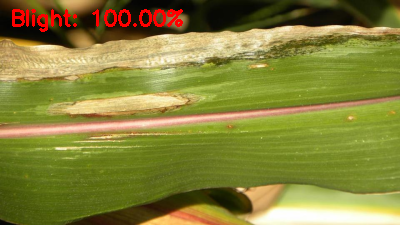

-1

In [32]:
# build the label
max_predict = max(a,b,c,d)

if a == max_predict:
  label = folders[0]
elif b == max_predict:
  label = folders[1]
elif c == max_predict:
  label = folders[2]
else:
    label = folders[3]

label = "{}: {:.2f}%".format(label, max_predict * 100)
# draw the label on the image
output = imutils.resize(orig, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0,0,255), 2)
# show the output image
cv2_imshow( output)
cv2.waitKey(0)